## Question 1

In [4]:
import numpy as np
import scipy
from scipy import integrate
from numpy.linalg import matrix_power


def Tables(n,P,Q):
    M = np.zeros((n + 1,n +1))
    M[0][0] = 1 - P
    M[0][1] = P
    M[1][0] = Q*(1-P)
    M[1][1] = ((1-P)*(1-Q)) + P*Q
    M[2][1] = Q * (1-P)
    M[n][n] = (1-Q)
    M[n][n-1] = Q
    M[n-2][n-1] = P*(1-Q)
    M[n-1][n-1] = ((1-P)*(1-Q)) + P*Q
    M[n-1][n] = P*(1-Q)
    for i in range (2, n - 1):
        M[i][i] = ((1-P)*(1-Q)) + P*Q
        M[i+1][i] = Q*(1-P)
        M[i-1][i] = P*(1-Q)
    return M

Matrix = Tables(10, 0.3, 0.4)
Matrix_fix = Matrix.T

print(Matrix_fix)

[[0.7  0.28 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.3  0.54 0.28 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.18 0.54 0.28 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.18 0.54 0.28 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.18 0.54 0.28 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.18 0.54 0.28 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.18 0.54 0.28 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.18 0.54 0.28 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.18 0.54 0.28 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.18 0.54 0.4 ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.18 0.6 ]]


[0.252665   0.2707125  0.17402947 0.11187609 0.07192034 0.0462345
 0.02972218 0.01910712 0.01228315 0.00789631 0.00355334]
1.000000000012453


Text(0, 0.5, 'Probability %')

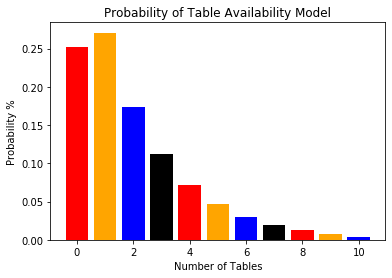

In [23]:
import matplotlib.pyplot as plt

state = [1,0,0,0,0,0,0,0,0,0,0]

Matrix_power = matrix_power(Matrix_fix, 1000000)

state_final = np.matmul(Matrix_power, state)

print(state_final)

tot = sum(state_final)

print(tot)

x = np.linspace(0,10,11)


plt.bar(x,state_final, color = ['red', 'orange', 'blue', 'black'])
plt.title('Probability of Table Availability Model')
plt.xlabel('Number of Tables')
plt.ylabel('Probability %')

## Question 2

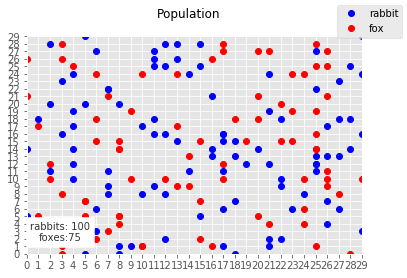

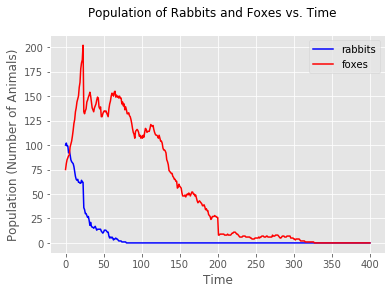

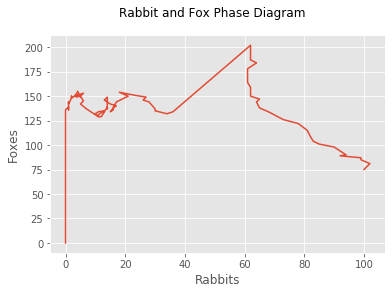

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation as animation
from scipy import integrate
from progressbar import progressbar as prbar        # (use pip/conda install progressbar2, or rewrite line 116.)
from copy import copy

RABBIT = 0
FOX = 1
#METEOR = 2


UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
STAY = 4

# initial number of rabbits and foxes
nrabbits = 20*5 #10*5
nfoxes = 15*5 #5*5
#nmeteor = 1

# size of the grid
gridxsize = 30*1
gridysize = 30*1

# energy of a freshly spawned rabbit/fox
rabben = 20*1.2
foxen = 20*1.2
#meteorn = 30*2

# chance of a new fox/rabbit being spawned at a gridpoint on a step
#rabbit_newborn_chance = 0.01*.001*6
#fox_newborn_chance = 0.01*.001
rabbit_newborn_chance = 0.01*.001*6
fox_newborn_chance = 0.01*0.001*4.5 #0.01*.001*3
#meteor_newborn_chance = 0.03*0.001*8
#rabbit_newborn_chance = 0.01*.001*3
#fox_newborn_chance = 0.01*.001*3

# number of steps to simulate
steps = int(400*1)


class Animal(object):
    """
    Tracks the animal's position, energy, species (rabbit/fox) and state (live/dead).
    """

    def __init__(self, x0, y0, init_energy, species):
        self.x = x0
        self.y = y0
        self.energy = init_energy
        self.species = species
        self.isDead = False


    def interact(self, other):
        """
        Interact with another animal:
            - If they're from the same species, ignore each other.
            - Fox eats rabbit.
        """
        if self.species == RABBIT and other.species == FOX:
            self.die()

        elif self.species == FOX and other.species == RABBIT:
            other.die()
        #elif self.species == METEOR and other.species == RABBIT & FOX:
        #    other.die()



    def die(self):
        "R.I.P"
        self.isDead = True


    def move(self, direction):
        """Move a step on the grid. Each step consumes 1 energy; if no energy left, die.
        If hitting the bounds of the grid, "bounde back", step to the opposite direction insetad.

        Arguments:
            direction {int} -- direction to move: UP: 0, DOWN: 1, LEFT: 2, RIGHT: 3, STAY: 4
        """
        self.energy -= 1

        if direction == LEFT:
            self.x += 1 if self.x > 0 else -1   #"bounce back"
        if direction == RIGHT:
            self.x -= 1 if self.x < gridxsize-1 else -1
        if direction == UP:
            self.y += 1 if self.y < gridysize-1 else -1
        if direction == DOWN:
            self.y -= 1 if self.y > 0 else -1
        if direction == STAY:
            pass

        if self.energy <= 0:
            self.die()          #R.I.P.



animals = []        # this will contain all animals on the grid


# all possible coordinate pair (following https://stackoverflow.com/a/11144716/5099168)
xcoords = np.arange(gridxsize)
ycoords = np.arange(gridysize)
coords = np.transpose([np.tile(xcoords, len(ycoords)), np.repeat(ycoords, len(xcoords))])

# populate grid randomly, unique coordinates for all animals
randcoords = np.random.permutation(coords)
rabbitcoords = randcoords[:nrabbits]
foxcoords = randcoords[nrabbits:(nrabbits + nfoxes)]

for (x, y) in rabbitcoords:
    animals.append(Animal(x0=x, y0=y, init_energy=rabben, species=RABBIT))
for (x, y) in foxcoords:
    animals.append(Animal(x0=x, y0=y, init_energy=foxen, species=FOX))


t_rabcoordsx = []   # track the coordinates of the animals in each step in these arrays
t_rabcoordsy = []
t_foxcoordsx = []
t_foxcoordsy = []

rabbitnums, foxnums = [nrabbits], [nfoxes]  #track the number of rabbits and foxes too

animfigs = []

xstart = 1
xstop = 28
ystart = 1
ystop = 28


for i in range(steps):          # NOTE: substitute with for i in range(steps) if progressbar2 is not installed

    # step with each animal in a random direction
    directions = np.random.randint(0, 5, size=len(animals))
    for animal, direction in zip(animals, directions):
        animal.move(direction)
        
    for h in np.arange(xstart, xstop,1):
        for n in np.arange(ystart, ystop,1):
            
            if i == steps/2:
                for j, animal1 in enumerate(animals):
                    for animal2 in animals[j:]:
                        if (animal1.x == h and
                            animal1.y == n):
                            animal1.die()


            if i == steps/2:
                for j, animal2 in enumerate(animals):
                    for animal1 in animals[j:]:
                        if (animal2.x == h and
                            animal2.y == n):
                            animal2.die()

    # generate newborn rabbits...
    if rabbitnums[i] > 0:
        rabbit_is_born_here = np.random.rand(len(coords)) <= rabbit_newborn_chance*rabbitnums[i]
        newrabbits = coords[rabbit_is_born_here]
        for (x, y) in newrabbits:
            animals.append(Animal(x0=x, y0=y, init_energy=rabben, species=RABBIT))

    #...  and foxes
    if foxnums[i] > 0:
        fox_is_born_here = np.random.rand(len(coords)) <= fox_newborn_chance*foxnums[i]
        newfoxes = coords[fox_is_born_here]
        for (x, y) in newfoxes:
            animals.append(Animal(x0=x, y0=y, init_energy=foxen, species=FOX))

    # interact if two animals are at the same coordinates
    for j, animal1 in enumerate(animals):
        for animal2 in animals[j:]:
            if (animal1.x == animal2.x and
                animal1.y == animal2.y):
                animal1.interact(animal2)

    # clean up corpses
    dead_indexes = []
    for j, animal in enumerate(animals):
        if animal.isDead:
            dead_indexes.append(j)
    animals = list(np.delete(animals, dead_indexes))

    # count animals and log
    foxnum, rabnum = 0,0
    for animal in animals:
        if animal.species == RABBIT:
            rabnum += 1
        elif animal.species == FOX:
            foxnum += 1
    rabbitnums.append(rabnum)
    foxnums.append(foxnum)
    # print(rabnum, foxnum, len(dead_indexes))

    # get and log animal coordinates
    rabcsx = []
    rabcsy = []
    foxcsx = []
    foxcsy = []
    for animal in animals:
        if animal.species == RABBIT:
            rabcsx.append(animal.x)
            rabcsy.append(animal.y)
            # ax.plot(, animal.y, 'bo')
        elif animal.species == FOX:
            foxcsx.append(animal.x)
            foxcsy.append(animal.y)
            # ax.plot(animal.x, animal.y, 'ro')

    t_rabcoordsx.append(rabcsx)
    t_rabcoordsy.append(rabcsy)
    t_foxcoordsx.append(foxcsx)
    t_foxcoordsy.append(foxcsy)


#Display the movement on an animation
fig, ax = plt.subplots()
fig.suptitle("Population")
ax.set_xlim(0, gridxsize-1)
ax.set_ylim(0, gridysize-1)
ax.set_xticks(xcoords)
ax.set_yticks(ycoords)
plt.grid(True)

rabpc, = ax.plot(t_rabcoordsx[0], t_rabcoordsy[0], 'bo', label='rabbit')
foxpc, = ax.plot(t_foxcoordsx[0], t_foxcoordsy[0], 'ro', label='fox')
fig.legend()

txt = ax.text(0.1, 0.1,'', ha='center', va='center', alpha=0.8,
              transform=ax.transAxes, fontdict={'color':'black', 'backgroundcolor': 'white', 'size': 10})

#initialize the animation:
def anim_init():
    rabpc.set_data(t_rabcoordsx[0], t_rabcoordsy[0])
    foxpc.set_data(t_foxcoordsx[0], t_foxcoordsy[0])
    txt.set_text('rabbits: {}\nfoxes:{}'.format(rabbitnums[0], foxnums[0]))
    return rabpc, foxpc, txt

#update the plot to the i-th frame:
def animate(i):
    rabpc.set_data(t_rabcoordsx[i], t_rabcoordsy[i])
    foxpc.set_data(t_foxcoordsx[i], t_foxcoordsy[i])
    txt.set_text('rabbits: {}\nfoxes:{}'.format(rabbitnums[i], foxnums[i]))
    return rabpc, foxpc, txt

#construct and display the animation
im_ani = animation.FuncAnimation(fig, animate, init_func=anim_init, frames=steps,
            interval=500, repeat=False, save_count=10, blit=True)
#im_ani.save('meteorAnimation.mp4')
plt.show()

plt.figure()
#plot population vs time
plt.plot(rabbitnums, 'b-', label="rabbits",)
plt.plot(foxnums, 'r-', label="foxes")
plt.xlabel('Time')
plt.ylabel('Population (Number of Animals)')
plt.suptitle("Population of Rabbits and Foxes vs. Time")
plt.legend()
plt.show()

plt.figure()
#plot rabbuts vs foxes
plt.suptitle("Rabbit and Fox Phase Diagram")
plt.plot(rabbitnums, foxnums)
plt.xlabel('Rabbits')
plt.ylabel('Foxes')
plt.show()

## Question 3

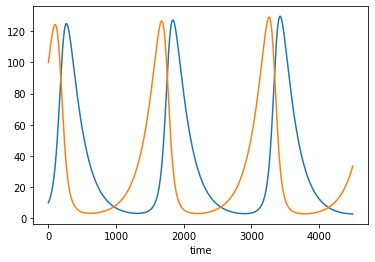

ModuleNotFoundError: No module named 'albopictus'

In [96]:
chickens = [100] 
foxes = [10]

chicken_birth_rate = 0.5
chicken_death_rate = 0.015
fox_birth_rate = 0.015
fox_death_rate = 0.5

delta_time = 0.01
cycles = 4500

for t in range(0, cycles):
  updated_chickens = chickens[t] + delta_time * (chicken_birth_rate * chickens[t]  - chicken_death_rate * foxes[t] * chickens[t])    
  updated_foxes = foxes[t] + delta_time * (-fox_death_rate * foxes[t] + fox_birth_rate * foxes[t] * chickens[t])
  chickens.append(updated_chickens)
  foxes.append(updated_foxes)

import matplotlib.pyplot as plt
plt.figure()
time_points = range(cycles + 1)
plt.plot(time_points, foxes)  
plt.plot(time_points, chickens) 
plt.xlabel('time')
plt.show()



##
## Python Script File for F1000 Research Manuscript
## sPop: age-structured discrete-time population dynamics model in C, Python, and R
##
## Copyright (C) 2018  Kamil Erguler
## 
##     This program is free software: you can redistribute it and/or modify
##     it under the terms of the GNU General Public License as published by
##     the Free Software Foundation, either version 3 of the License, or
##     any later version.
## 
##     This program is distributed in the hope that it will be useful,
##     but WITHOUT ANY WARRANTY; without even the implied warranty of
##     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
##     GNU General Public License for more details (<https://www.gnu.org/licenses/>).
## 
## Section 3.2. Python ------------------------------------------------------------

## Load the spop class from the population package of the albopictus bundle
import albopictus
from albopictus.population import spop

## Declare the survival function as defined in Eqn. 1
def death(pop):
    if pop.shape[1]==0:
        return [480.0, 48.0]
    mn = 480.0 - 48.0 * pop[:,1]
    mn[mn < 240.0] = 240.0
    return [mn, 0.1*mn]

## Run a stochastic simulation 100 times
for j in range(100):
    ## Create a stochastic population of class spop using the gamma distribution as
    ## the basis of survival and development
    vec = spop(stochastic=True,prob="gamma")
    ## Add 1000 individuals to the population (age=0, devcycle=0, development=0)
    vec.add([[0,0,0,1000]])
    ## Iterate for 720 time units (hours)
    for i in range(720):
        ## Calculate death_mean and death_sd for each age-development group
        tmp = death(vec.pop)
        ## Iterate for 1 time unit
        vec.iterate(dev_mean = 50,
                    dev_sd = 10,
                    death_mean = tmp[0],
                    death_sd = tmp[1])
        ## Record the total number of individuals completing development
        d = vec.developed
        ## Reintroduce to the population all individuals which completed their development
        ## for the next round of development
        vec.add(vec.devtable)
        ## Record the size of the population
        s = vec.size
        ## Print out the results
        print("1,%d,%d,%d" %(i,s,d))

## Create a deterministic population of class spop using the gamma distribution as
## the basis of survival and development
vec = spop(stochastic=True,prob="gamma")
## Add 1000 individuals to the population (age=0, devcycle=0, development=0)
vec.add([[0,0,0,1000]])
## Iterate for 720 time units (hours)
for i in range(720):
    ## Calculate death_mean and death_sd for each age-development group
    tmp = death(vec.pop)
    ## Iterate for 1 time unit
    vec.iterate(dev_mean = 50,
                dev_sd = 10,
                death_mean = tmp[0],
                death_sd = tmp[1])
    ## Record the total number of individuals completing development
    d = vec.developed
    ## Reintroduce to the population all individuals which completed their development
    ## for the next round of development
    vec.add(vec.devtable)
    ## Record the size of the population
    s = vec.size
    ## Print out the results
    print("0,%d,%g,%g" %(i,s,d))








import numpy as np  ################# CONDA INSTALL PROGRESSBAR2
import matplotlib.pyplot as plt
from matplotlib import animation as animation
from scipy import integrate
from progressbar import progressbar as prbar        # (use pip/conda install progressbar2, or rewrite line 116.)
from copy import copy

RABBIT = 0
FOX = 1

UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
STAY = 4

# initial number of rabbits and foxes
nrabbits = 10
nfoxes = 5

# size of the grid
gridxsize = 30
gridysize = 30

# energy of a freshly spawned rabbit/fox
rabben = 20
foxen = 20

# chance of a new fox/rabbit being spawned at a gridpoint on a step
rabbit_newborn_chance = 0.50
fox_newborn_chance = 0.02

# number of steps to simulate
steps = 200


class Animal(object):
    """
    Tracks the animal's position, energy, species (rabbit/fox) and state (live/dead).
    """

    def __init__(self, x0, y0, init_energy, species):
        self.x = x0
        self.y = y0
        self.energy = init_energy
        self.species = species
        self.isDead = False


    def interact(self, other):
        """
        Interact with another animal:
            - If they're from the same species, ignore each other.
            - Fox eats rabbit.
        """
        if self.species == RABBIT and other.species == FOX:
            self.die()

        elif self.species == FOX and other.species == RABBIT:
            other.die()



    def die(self):
        "R.I.P"
        self.isDead = True


    def move(self, direction):
        """Move a step on the grid. Each step consumes 1 energy; if no energy left, die.
        If hitting the bounds of the grid, "bounde back", step to the opposite direction insetad.

        Arguments:
            direction {int} -- direction to move: UP: 0, DOWN: 1, LEFT: 2, RIGHT: 3, STAY: 4
        """
        self.energy -= 1

        if direction == LEFT:
            self.x += 1 if self.x > 0 else -1   #"bounce back"
        if direction == RIGHT:
            self.x -= 1 if self.x < gridxsize-1 else -1
        if direction == UP:
            self.y += 1 if self.y < gridysize-1 else -1
        if direction == DOWN:
            self.y -= 1 if self.y > 0 else -1
        if direction == STAY:
            pass

        if self.energy <= 0:
            self.die()          #R.I.P.



animals = []        # this will contain all animals on the grid


# all possible coordinate pair (following https://stackoverflow.com/a/11144716/5099168)
xcoords = np.arange(gridxsize)
ycoords = np.arange(gridysize)
coords = np.transpose([np.tile(xcoords, len(ycoords)), np.repeat(ycoords, len(xcoords))])

# populate grid randomly, unique coordinates for all animals
randcoords = np.random.permutation(coords)
rabbitcoords = randcoords[:nrabbits]
foxcoords = randcoords[nrabbits:(nrabbits + nfoxes)]

for (x, y) in rabbitcoords:
    animals.append(Animal(x0=x, y0=y, init_energy=rabben, species=RABBIT))
for (x, y) in foxcoords:
    animals.append(Animal(x0=x, y0=y, init_energy=foxen, species=FOX))


t_rabcoordsx = []   # track the coordinates of the animals in each step in these arrays
t_rabcoordsy = []
t_foxcoordsx = []
t_foxcoordsy = []

rabbitnums, foxnums = [nrabbits], [nfoxes]  #track the number of rabbits and foxes too

animfigs = []

for i in prbar(range(steps), max_value = steps, redirect_stdout=True):          # NOTE: substitute with for i in range(steps) if progressbar2 is not installed

    # step with each animal in a random direction
    directions = np.random.randint(0, 5, size=len(animals))
    for animal, direction in zip(animals, directions):
        animal.move(direction)

    # generate newborn rabbits...
    rabbit_is_born_here = np.random.rand(len(coords)) <= rabbit_newborn_chance
    newrabbits = coords[rabbit_is_born_here]
    for (x, y) in newrabbits:
        animals.append(Animal(x0=x, y0=y, init_energy=rabben, species=RABBIT))

    #...  and foxes
    fox_is_born_here = np.random.rand(len(coords)) <= fox_newborn_chance
    newfoxes = coords[fox_is_born_here]
    for (x, y) in newfoxes:
        animals.append(Animal(x0=x, y0=y, init_energy=foxen, species=FOX))

    # interact if two animals are at the same coordinates
    for j, animal1 in enumerate(animals):
        for animal2 in animals[j:]:
            if (animal1.x == animal2.x and
                animal1.y == animal2.y):
                animal1.interact(animal2)

    # clean up corpses
    dead_indexes = []
    for j, animal in enumerate(animals):
        if animal.isDead:
            dead_indexes.append(j)
    animals = list(np.delete(animals, dead_indexes))

    # count animals and log
    foxnum, rabnum = 0,0
    for animal in animals:
        if animal.species == RABBIT:
            rabnum += 1
        elif animal.species == FOX:
            foxnum += 1
    rabbitnums.append(rabnum)
    foxnums.append(foxnum)
    # print(rabnum, foxnum, len(dead_indexes))

    # get and log animal coordinates
    rabcsx = []
    rabcsy = []
    foxcsx = []
    foxcsy = []
    for animal in animals:
        if animal.species == RABBIT:
            rabcsx.append(animal.x)
            rabcsy.append(animal.y)
            # ax.plot(, animal.y, 'bo')
        elif animal.species == FOX:
            foxcsx.append(animal.x)
            foxcsy.append(animal.y)
            # ax.plot(animal.x, animal.y, 'ro')

    t_rabcoordsx.append(rabcsx)
    t_rabcoordsy.append(rabcsy)
    t_foxcoordsx.append(foxcsx)
    t_foxcoordsy.append(foxcsy)


#Display the movement on an animation
fig, ax = plt.subplots()
fig.suptitle("Hunger Games")
ax.set_xlim(0, gridxsize-1)
ax.set_ylim(0, gridysize-1)
ax.set_xticks(xcoords)
ax.set_yticks(ycoords)
plt.grid(True)

rabpc, = ax.plot(t_rabcoordsx[0], t_rabcoordsy[0], 'bo', label='rabbit')
foxpc, = ax.plot(t_foxcoordsx[0], t_foxcoordsy[0], 'ro', label='fox')
fig.legend()

txt = ax.text(0.1, 0.1,'', ha='center', va='center', alpha=0.8,
              transform=ax.transAxes, fontdict={'color':'black', 'backgroundcolor': 'white', 'size': 10})

#initialize the animation:
def anim_init():
    rabpc.set_data(t_rabcoordsx[0], t_rabcoordsy[0])
    foxpc.set_data(t_foxcoordsx[0], t_foxcoordsy[0])
    txt.set_text('rabbits: {}\nfoxes:{}'.format(rabbitnums[0], foxnums[0]))
    return rabpc, foxpc, txt

#update the plot to the i-th frame:
def animate(i):
    rabpc.set_data(t_rabcoordsx[i], t_rabcoordsy[i])
    foxpc.set_data(t_foxcoordsx[i], t_foxcoordsy[i])
    txt.set_text('rabbits: {}\nfoxes:{}'.format(rabbitnums[i], foxnums[i]))
    return rabpc, foxpc, txt

#construct and display the animation
im_ani = animation.FuncAnimation(fig, animate, init_func=anim_init, frames=steps,
            interval=500, repeat=False, save_count=10, blit=True)
plt.show()


#plot population vs time
plt.plot(rabbitnums, 'b-', label="rabbits",)
plt.plot(foxnums, 'r-', label="foxes")
plt.xlabel('t')
plt.ylabel('population')
plt.suptitle("Population VS time")
plt.legend()
plt.show()

#plot rabbuts vs foxes
plt.suptitle("Rabbit vs fox population")
plt.plot(rabbitnums, foxnums)
plt.xlabel('rabbits')
plt.ylabel('foxes')
plt.show()

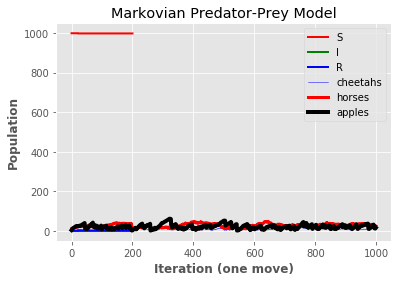

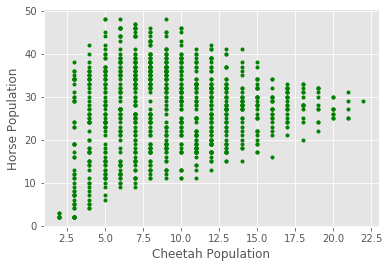

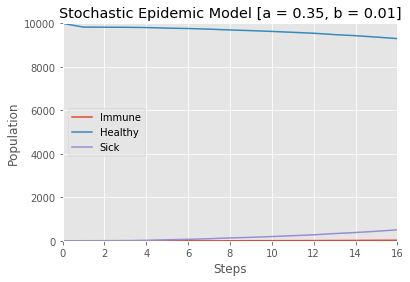

TypeError: '>' not supported between instances of 'int' and 'tuple'

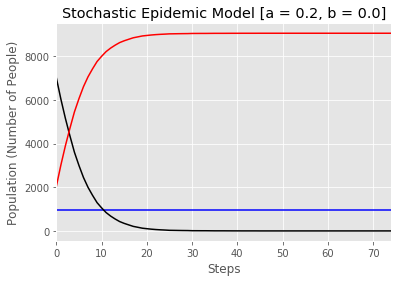

In [4]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

#pythran export sirp(float64 list, float64 list, float64)
def sirp(u,parms,t):
    bet,gamm,iota,N,dt=parms
    S,I,R,Y=u
    lambd = bet*(I+iota)/N
    ifrac = 1.0 - math.exp(-lambd*dt)
    rfrac = 1.0 - math.exp(-gamm*dt)
    infection = np.random.binomial(S,ifrac)
    recovery = np.random.binomial(I,rfrac)
    return [S-infection,I+infection-recovery,R+recovery,Y+infection]

#pythran export simulatep()
def simulatep():
    parms = [0.1, 0.05, 0.01, 1000.0, 0.1]
    tf = 200
    tl = 2001
    t = np.linspace(0,tf,tl)
    S = np.zeros(tl)
    I = np.zeros(tl)
    R = np.zeros(tl)
    Y = np.zeros(tl)
    u = [999,1,0,0]
    S[0],I[0],R[0],Y[0] = u
    for j in range(1,tl):
        u = sirp(u,parms,t[j])
        S[j],I[j],R[j],Y[j] = u
    return {'t':t,'S':S,'I':I,'R':R,'Y':Y}
#%timeit simulatep()
sir_out = pd.DataFrame(simulatep())
sir_out

plt.style.use("ggplot")
sline = plt.plot("t","S","",data=sir_out,color="red",linewidth=2)
iline = plt.plot("t","I","",data=sir_out,color="green",linewidth=2)
rline = plt.plot("t","R","",data=sir_out,color="blue",linewidth=2)
plt.xlabel("Time",fontweight="bold")
plt.ylabel("Number",fontweight="bold")
legend = plt.legend(title="Population",loc=5,bbox_to_anchor=(1.25,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)





import numpy as np
import matplotlib.pylab as plt
from scipy.integrate import odeint
import random
from collections import Counter


# Starting points

def move(pos):
	#possible moves
	pmoves = [-1,0,1]
	#print pos

	# coordinants
	coords = []
	for i in pmoves:
		for j in pmoves:
			coords.append([pos[0]+i,pos[1]+j])
	#print coords
	for k in coords:
		if k == pos:
			coords.remove(k)
	newpos = random.choice(coords)
	#print newpos

	#----------------------
	#wraps the field

	newpos = np.asarray(newpos)
	#print newpos

	if newpos[0] == 31:
		np.put(newpos,0,0)
	if newpos[1] == 31:
		np.put(newpos,1,0)
	if newpos[0] == -1:
		np.put(newpos,0,30)
	if newpos[1] == -1:
		np.put(newpos,1,30)
	#----------------------

	newpos = newpos.tolist()
	#print newpos
	return newpos


def nature(ding, kang, wolf):
	npkang = []
	npding = []
	npwolf = []
	global kangsex
	global dingsex
	global wolfsex
	
	for k in range(len(kang)):
		npkang.append(move(kang[k]))

	for n in range(len(ding)):
		npding.append(move(ding[n]))
	
	for wo in range(len(wolf)):
		npwolf.append(move(wolf[wo]))
	
	for m in npding:
		for j in npkang:
			if m == j:
				npkang.pop(0)

	for h in npwolf:
		for u in npding:
			if h == u:
				npding.pop(0)

	for y in npwolf:
		for t in npkang:
			if y == t:
				npkang.pop(0)
	
	if random.random() < .5:
		kanga = np.asarray(npkang)
		for b in kanga:
			kangsex = np.unique(b)
		for l in range(len(kangsex)):
			npkang.append([random.randrange(0,31),random.randrange(0,31)])

	dingo = np.asarray(npding)
	for q in dingo:
		dingsex = np.unique(q)
	if random.random() < .5:
		for d in range(len(dingsex)):
			npding.append([random.randrange(0,31),random.randrange(0,31)])
	
	if random.random() < .8:
		wolfs = np.asarray(npwolf)
		for e in wolfs:
			wolfsex = np.unique(e)
		for r in range(len(wolfsex)):
			npwolf.append([random.randrange(0,31),random.randrange(0,31)])	

	if len(npding) > 2*len(npkang) and random.random() < .75:
		if len(npding) > 3:
			npding.pop()

	if random.random() < .8:
		if len(npding) > 3:
			npding.pop(0)

	if random.random() < .01 and random.random() < .1:
		npding = []
		npkang = []
		npwolf = []
		for g in range(2):
			npding.append([random.randrange(0,31),random.randrange(0,31)])
			npkang.append([random.randrange(0,31),random.randrange(0,31)])
			npwolf.append([random.randrange(0,31),random.randrange(0,31)])
		
	if len(npwolf) > 3*len(npding):
		if len(npwolf) > 3:
			npwolf.pop()

	if random.random() < .1 and len(npwolf) > 3:
		for ds in range(len(npwolf)//2):
			npwolf.pop(0)
	
	
	return npding, npkang, npwolf


#-------------------
#Randomly places healthy people and sick person on grid

kang = []
ding = []
wolf = []

for k in range(10):
	kang.append([random.randrange(0,31),random.randrange(0,31)])

for d in range(5):
	ding.append([random.randrange(0,31),random.randrange(0,31)])

for w in range(2):
	wolf.append([random.randrange(0,31),random.randrange(0,31)])
# Runs until all the kangaroos are dead
iteration = []
lend = []
lenk = []
lenw = []
i = 0
#while len(ding) != 0:
while i < 1000:
	ding, kang, wolf = nature(ding,kang, wolf) 
	#print len(ding), len(kang)
	lend.append(len(ding))
	lenk.append(len(kang))
	lenw.append(len(wolf))
	iteration.append(i)
	i += 1
	#print i

#print lenh,lens,leni
#print lens
plt.plot(iteration, lend, 'b', linewidth = .5, label = 'cheetahs')
plt.plot(iteration, lenk, 'r', linewidth = 3, label = 'horses')
plt.plot(iteration, lenw, 'k', linewidth = 4, label = 'apples')
plt.title("Markovian Predator-Prey Model")
#plt.xlim(-1,1000)
plt.legend(loc = 'best')
plt.xlabel('Iteration (one move)')
plt.ylabel('Population')
plt.show()

plt.figure()
plt.plot(lend, lenk, 'g.')
plt.xlabel('Cheetah Population')
plt.ylabel('Horse Population')
plt.show()





import numpy as np
import scipy as sc
import numba as nb
import matplotlib.pyplot as plt
import matplotlib.animation as animation


#This code is from a programming modeling class that is an implementation of
#Markov Chain methods on an epidemic simulation for a 2-D environment. This
#code creates an array with randomly assigned values representative of a type
#of individual (healthy, immune, or sick) and proceeds to play out the spread of
#disease between neighboring indivuals. A graph and animation are produced.



# Assigning variables
# Healthy (1), Immune (2), Sick (3)
imm_count = 0 # creating immune counter
hea_count = 0 # creating healthy counter
sic_count = 0 # creating sick counter
alpha = 0.35 # probability of getting sick given an interaction
beta = 0.01 # probability of becoming immune to disease
imm_prop = 0.00 # proportion of immune
sic_prop = 0.000 # proportion of sick
immune_count = [] # creating immune counter list
healthy_count = [] # creating healthy counter list
sick_count = [] # creating sick counter list
itera = 17 # amount of iterations to run

# Generate an array with dimensions Dim X Dim with all zeros
Dim = 100 # dimension of the grid, square
total_pop = Dim*Dim
grid = np.zeros([Dim,Dim]) # creates empty grid

# Randomly assign each grid position a value from 0 to 1 to designate status
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        grid[i,j] = np.random.rand(1)
        # For example, this method has 5% immune (2), 20% sick (3), and 75% healthy (1)
        if grid[i,j] < imm_prop:
            grid[i,j] = 2
            imm_count +=1
        elif grid[i,j] < sic_prop:
            grid[i,j] = 3
            sic_count += 1
        else:
            grid[i,j] = 1
            hea_count += 1
        #grid[10:25,15:35] = 4
        grid[50,70] = 3
        grid[40:80,50] = 4
        grid[40:80,96] = 4
        grid[40,50:96] = 4
        grid[80,50:87] = 4
        grid[80,88:96] = 4

# Creating and updating population lists
initial_pop = [] # creating initial total population list
initial_pop = healthy_count, immune_count, sick_count
sick_count.append(sic_count)
healthy_count.append(hea_count)
immune_count.append(imm_count)

#print('healthy,immune,sick')
#print(initial_pop)

# Creating stochastic, grid updating function
#@nb.jit
def updategrid(grid):
# make sure the grid sizes are equal
    if grid.shape[0] == grid.shape[1]:
        x = grid.shape[0]
    else:
        raise IndexError('Bad')
        gridnew = grid.copy()
        v_size, h_size = grid.shape
    
    for i in range(x):
        for j in range(x):
            gridnew = grid
            # If the space is not empty, then it can move.
            # Randomly determining the direction it will move
            if grid[i,j] != 0:
                random_num = np.random.rand(1)
        
            if random_num < 0.25 and gridnew[(i+1)%x,j] == 0:
                gridnew[(i+1)%x,j] = grid[i,j]
                gridnew[i,j] = 0
            else:
                gridnew[i,j] = grid[i,j]
        
            if random_num < 0.5 and gridnew[(i-1)%x,j] == 0:
                gridnew[(i-1)%x,j] = grid[i,j]
                gridnew[i,j] = 0
            else:
                gridnew[i,j] = grid[i,j]
        
            if random_num < 0.75 and gridnew[i,(j+1)%x] == 0:
                gridnew[i,(j+1)%x] = grid[i,j]
                gridnew[i,j] = 0
            else:
                gridnew[i,j] = grid[i,j]
        
            if random_num < 1 and gridnew[i,(j-1)%x] == 0:
                gridnew[i,(j-1)%x] = grid[i,j]
                gridnew[i,j] = 0
            else:
                gridnew[i,j] = grid[i,j]

# If any surrounding grid point is popuated by a sick person, then spread the sickness
# if the random number is less than the probabiliy of getting sick

            prob = np.random.rand(1)
            prob2 = np.random.rand(1)
            
            if prob < alpha:
                if gridnew[i,j] == 1:
                    if (gridnew[(i+1)%x,j] == 3 or gridnew[(i-1)%x,j] == 3
                        or gridnew[i,(j+1)%x] == 3 or gridnew[i,(j-1)%x] == 3):
                        gridnew[i,j] = 3
            
            if prob2 < beta:
                if gridnew[i,j] == 3:
                    gridnew[i,j] = 2
    #grid[10:25,15:35] = 4
    grid[40:80,50] = 4
    grid[40:80,96] = 4
    grid[40,50:96] = 4
    grid[80,50:87] = 4
    grid[80,88:96] = 4
    return gridnew

# Creating grid animation
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
fig.suptitle("Stochastic Epidemic Model [a = {}, b = {}]".format(alpha,beta))
grids = []
image = ax.imshow(grid, cmap='bwr')
grids.append([image])

for k in range(itera-1):
    grid = updategrid(grid)
    s_count = np.sum(grid == 3)
    h_count = np.sum(grid == 1)
    i_count = np.sum(grid == 2)
    sick_count.append(s_count)
    healthy_count.append(h_count)
    immune_count.append(i_count)
    image = ax.imshow(grid, cmap='bwr')
    grids.append([image])
    plt.close()

# Plotting Population over Steps
steps = np.linspace(0,itera-1,itera)
plt.plot(steps, immune_count, label = "Immune")
plt.plot(steps, healthy_count, label = "Healthy")
plt.plot(steps, sick_count, label = "Sick")
plt.xlabel('Steps')
plt.ylabel('Population')
plt.title("Stochastic Epidemic Model [a = {}, b = {}]".format(alpha, beta))
plt.xlim(0,itera-1)
plt.ylim(0,total_pop)
#plt.text((itera/3), (total_pop/2), "{} Healthy, {} Immune, {} Sick Initially".format(hea_count,imm_count,sic_count))
plt.legend(loc="center left")
#plt.savefig('epidemic_plot_{}_{}.png'.format(alpha,beta),format = 'png', dpi = 600, bbox_inches='tight')
#plt.close()
plt.show()

# Animating Simulation of Grid Space
# requires ffmpeg
ani=animation.PillowWriter(fig, grids)
#ani = animation.ArtistAnimation(fig, grids, blit=True)
#ani.save("epidemic-animation-{}-{}.mp4".format(alpha,beta), dpi=300, fps=10, extra_args=['-vcodec', 'libx264'])
plt.show()




import numpy as np #USE THIS CODE USE THIS CODE USE THIS CODE USE THIS CODE
import scipy as sc
import numba as nb
import matplotlib.pyplot as plt
import matplotlib.animation as animation



# Assigning variables #USE THIS CODE USE THIS CODE USE THIS CODE USE THIS CODE#USE THIS CODE USE THIS CODE USE THIS CODE USE THIS CODE
# Healthy (1), Immune (2), Sick (3)
imm_count = 0 # creating immune counter
hea_count = 0 # creating healthy counter
sic_count = 0 # creating sick counter
alpha = 0.20#0.25 # probability of getting sick given an interaction
beta = 0.0#0.05 # probability of becoming immune to disease
line = 0.1
imm_prop = 0.10#0.05 # proportion of immune
sic_prop = 0.30#0.20 # proportion of sick
immune_count = [] # creating immune counter list
healthy_count = [] # creating healthy counter list
sick_count = [] # creating sick counter list
itera = 75 # amount of iterations to run

# Generate an array with dimensions Dim X Dim with all zeros
Dim = 100 # dimension of the grid, square
total_pop = Dim,Dim
grid = np.zeros([Dim,Dim]) # creates empty grid

# Randomly assign each grid position a value from 0 to 1 to designate status
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        grid[i,j] = np.random.rand(1)
        # For example, this method has 5% immune (2), 20% sick (3), and 75% healthy (1)
        if grid[i,j] < imm_prop:
            grid[i,j] = 2
            imm_count +=1
        elif grid[i,j] < sic_prop:
            grid[i,j] = 3
            sic_count += 1
        else:
            grid[i,j] = 1
            hea_count += 1
        #grid[10:25,15:35] = 4


# Creating and updating population lists
initial_pop = [] # creating initial total population list
initial_pop = healthy_count, immune_count, sick_count
sick_count.append(sic_count)
healthy_count.append(hea_count)
immune_count.append(imm_count)

#print('healthy,immune,sick')
#print(initial_pop)

# Creating stochastic, grid updating function
#@nb.jit
def updategrid(grid):
# make sure the grid sizes are equal
    if grid.shape[0] == grid.shape[1]:
        x = grid.shape[0]
    else:
        raise IndexError('Bad')
        gridnew = grid.copy()
        v_size, h_size = grid.shape
    
    for i in range(x):
        for j in range(x):
            gridnew = grid
            # If the space is not empty, then it can move.
            # Randomly determining the direction it will move
            if grid[i,j] != 0:
                random_num = np.random.rand(1)
        
            if random_num < 0.25 and gridnew[(i+1)%x,j] == 0:
                gridnew[(i+1)%x,j] = grid[i,j]
                gridnew[i,j] = 0
            else:
                gridnew[i,j] = grid[i,j]
        
            if random_num < 0.5 and gridnew[(i-1)%x,j] == 0:
                gridnew[(i-1)%x,j] = grid[i,j]
                gridnew[i,j] = 0
            else:
                gridnew[i,j] = grid[i,j]
        
            if random_num < 0.75 and gridnew[i,(j+1)%x] == 0:
                gridnew[i,(j+1)%x] = grid[i,j]
                gridnew[i,j] = 0
            else:
                gridnew[i,j] = grid[i,j]
        
            if random_num < 1 and gridnew[i,(j-1)%x] == 0:
                gridnew[i,(j-1)%x] = grid[i,j]
                gridnew[i,j] = 0
            else:
                gridnew[i,j] = grid[i,j]

# If any surrounding grid point is popuated by a sick person, then spread the sickness
# if the random number is less than the probabiliy of getting sick

            prob = np.random.rand(1)
            prob2 = np.random.rand(1)
            #prob3 = np.random.rand(1)
            
            if prob < alpha:
                if gridnew[i,j] == 1:
                    if (gridnew[(i+1)%x,j] == 3 or gridnew[(i-1)%x,j] == 3
                        or gridnew[i,(j+1)%x] == 3 or gridnew[i,(j-1)%x] == 3):
                        gridnew[i,j] = 3
            
            if prob2 < beta:
                if gridnew[i,j] == 3:
                    gridnew[i,j] = 2

            #if prob3 < line:
                #if gridnew[i,j] == 3:
                    #gridnew[i,j] = 1


    return gridnew

# Creating grid animation
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
fig.suptitle("Stochastic Epidemic Model [a = {}, b = {}]".format(alpha,beta))
grids = []
image = ax.imshow(grid, cmap='bwr')
grids.append([image])

for k in range(itera-1):
    grid = updategrid(grid)
    s_count = np.sum(grid == 3)
    h_count = np.sum(grid == 1)
    i_count = np.sum(grid == 2)
    sick_count.append(s_count)
    healthy_count.append(h_count)
    immune_count.append(i_count)
    image = ax.imshow(grid, cmap='bwr')
    grids.append([image])
    plt.close()

# Plotting Population over Steps
steps = np.linspace(0,itera-1,itera)
plt.plot(steps, immune_count, color = "blue", label = "Immune")
plt.plot(steps, healthy_count, color = "black", label = "Healthy")
plt.plot(steps, sick_count, color = "red", label = "Sick")
plt.xlabel('Steps')
plt.ylabel('Population (Number of People)')
plt.title("Stochastic Epidemic Model [a = {}, b = {}]".format(alpha, beta))
plt.xlim(0,itera-1)
plt.ylim(0,total_pop)
#plt.text((itera/3), (total_pop/2), "{} Healthy, {} Immune, {} Sick Initially".format(hea_count,imm_count,sic_count))
plt.legend(loc="center left")
#plt.savefig('epidemic_plot_{}_{}.png'.format(alpha,beta),format = 'png', dpi = 600, bbox_inches='tight')
#plt.close()

# Animating Simulation of Grid Space
# requires ffmpeg
#ani=animation.ArtistAnimation(fig, grids)
ani = animation.ArtistAnimation(fig, grids, blit=True)
#ani.save("epidemic-animation-{}-{}.mp4".format(alpha,beta), dpi=300, fps=10, extra_args=['-vcodec', 'libx264'])
plt.show()